In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from IPython.display import display, IFrame

print(__version__)  # need 1.9.0 or greater
init_notebook_mode(connected=True)

5.21.0


In [2]:
def plotly_df(df, title="", width=800, height=500):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode="lines")
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)

    # in a Jupyter Notebook, the following should work
    #iplot(fig, show_link=False)

    # in a Jupyter Book, we save a plot offline and then render it with IFrame
    plot_path = f"../../_static/plotly_htmls/{title}.html".replace(" ", "_")
    plot(fig, filename=plot_path, show_link=False, auto_open=False);
    display(IFrame(plot_path, width=width, height=height))

In [3]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [4]:
df = pd.read_csv(DATA_PATH + "wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [5]:
df.shape

(383, 7)

In [6]:
df.date = pd.to_datetime(df.date)

In [8]:
from prophet import Prophet

In [9]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
df.tail()

train_df = df[:-predictions].copy()

In [10]:
m = Prophet()
m.fit(train_df);

future = m.make_future_dataframe(periods=predictions)
future.tail()

forecast = m.predict(future)
forecast.tail()

20:58:12 - cmdstanpy - INFO - Chain [1] start processing
20:58:12 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2975.100998,1708.686188,2504.739423,2955.573436,2994.253224,-862.545964,-862.545964,-862.545964,-862.545964,-862.545964,-862.545964,0.0,0.0,0.0,2112.555034
379,2016-01-17,2980.432400,1840.593107,2676.646875,2958.942266,3000.724323,-721.525739,-721.525739,-721.525739,-721.525739,-721.525739,-721.525739,0.0,0.0,0.0,2258.906661
380,2016-01-18,2985.763803,2874.962648,3680.166406,2962.801409,3007.282020,281.375854,281.375854,281.375854,281.375854,281.375854,281.375854,0.0,0.0,0.0,3267.139657
381,2016-01-19,2991.095205,3123.063363,3951.926322,2966.948475,3013.898892,542.213022,542.213022,542.213022,542.213022,542.213022,542.213022,0.0,0.0,0.0,3533.308227
382,2016-01-20,2996.426608,3031.471899,3820.268512,2970.660617,3020.604880,426.073193,426.073193,426.073193,426.073193,426.073193,426.073193,0.0,0.0,0.0,3422.499801


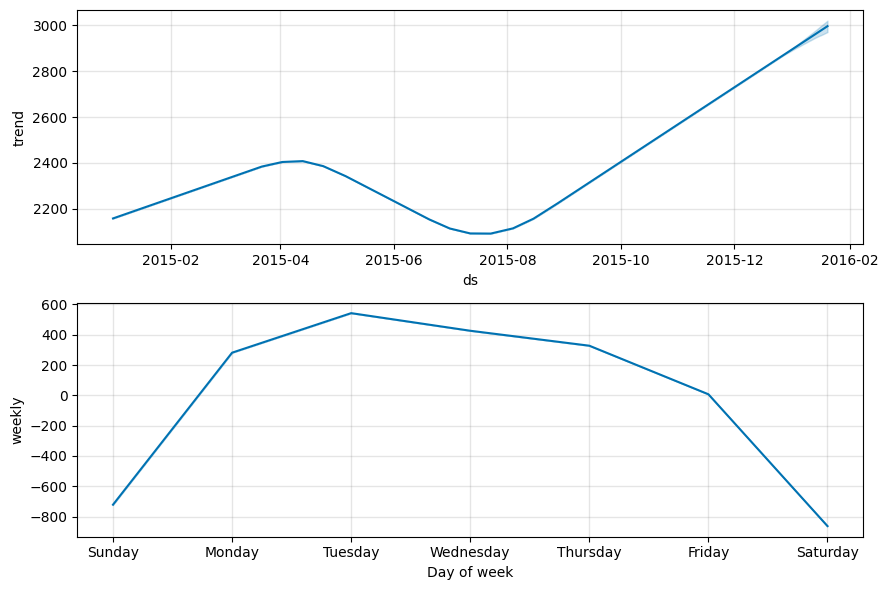

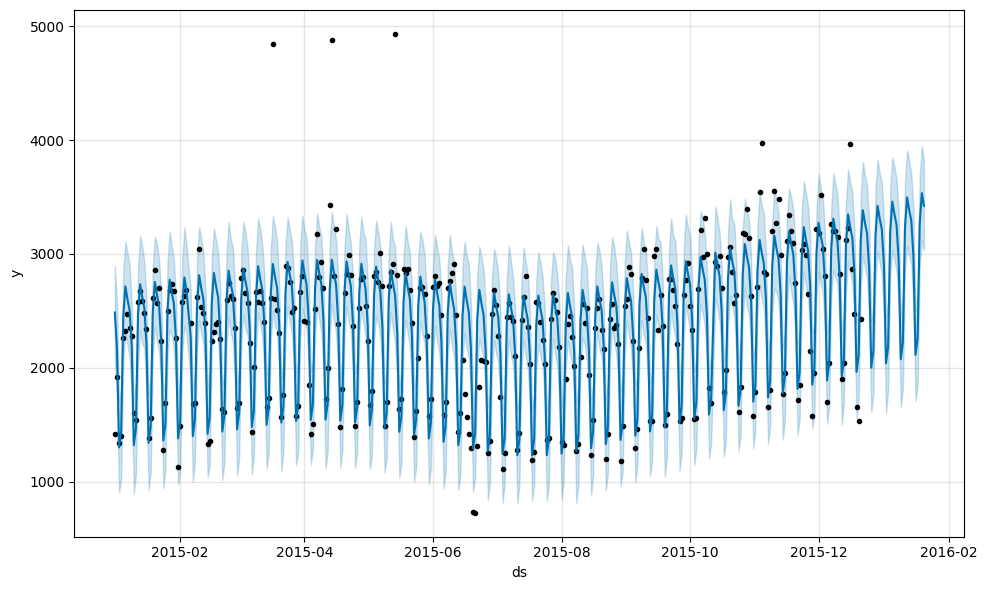

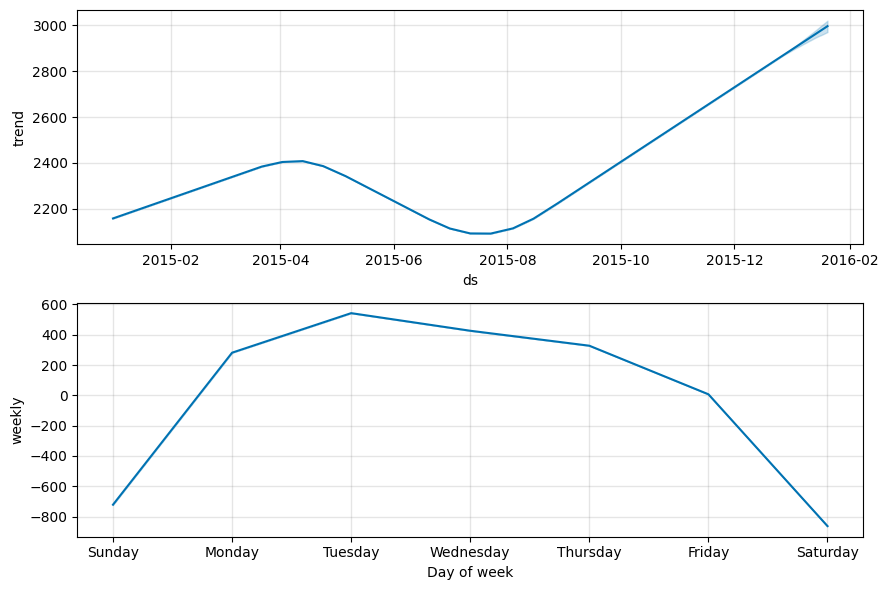

In [11]:
m.plot(forecast)
m.plot_components(forecast)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

cmp_df = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
    df.set_index("ds")
)

cmp_df["e"] = cmp_df["y"] - cmp_df["yhat"]
cmp_df["p"] = 100 * cmp_df["e"] / cmp_df["y"]

mape = mean_absolute_percentage_error(cmp_df[-predictions:]["y"], cmp_df[-predictions:]["yhat"])
mae = mean_absolute_error(cmp_df[-predictions:]["y"], cmp_df[-predictions:]["yhat"])

print("MAPE =", round(mape, 2))
print("MAE =", round(mae, 2))

MAPE = 0.34
MAE = 596.73


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

plt.rcParams["figure.figsize"] = (15, 10)

0.10739219627612018


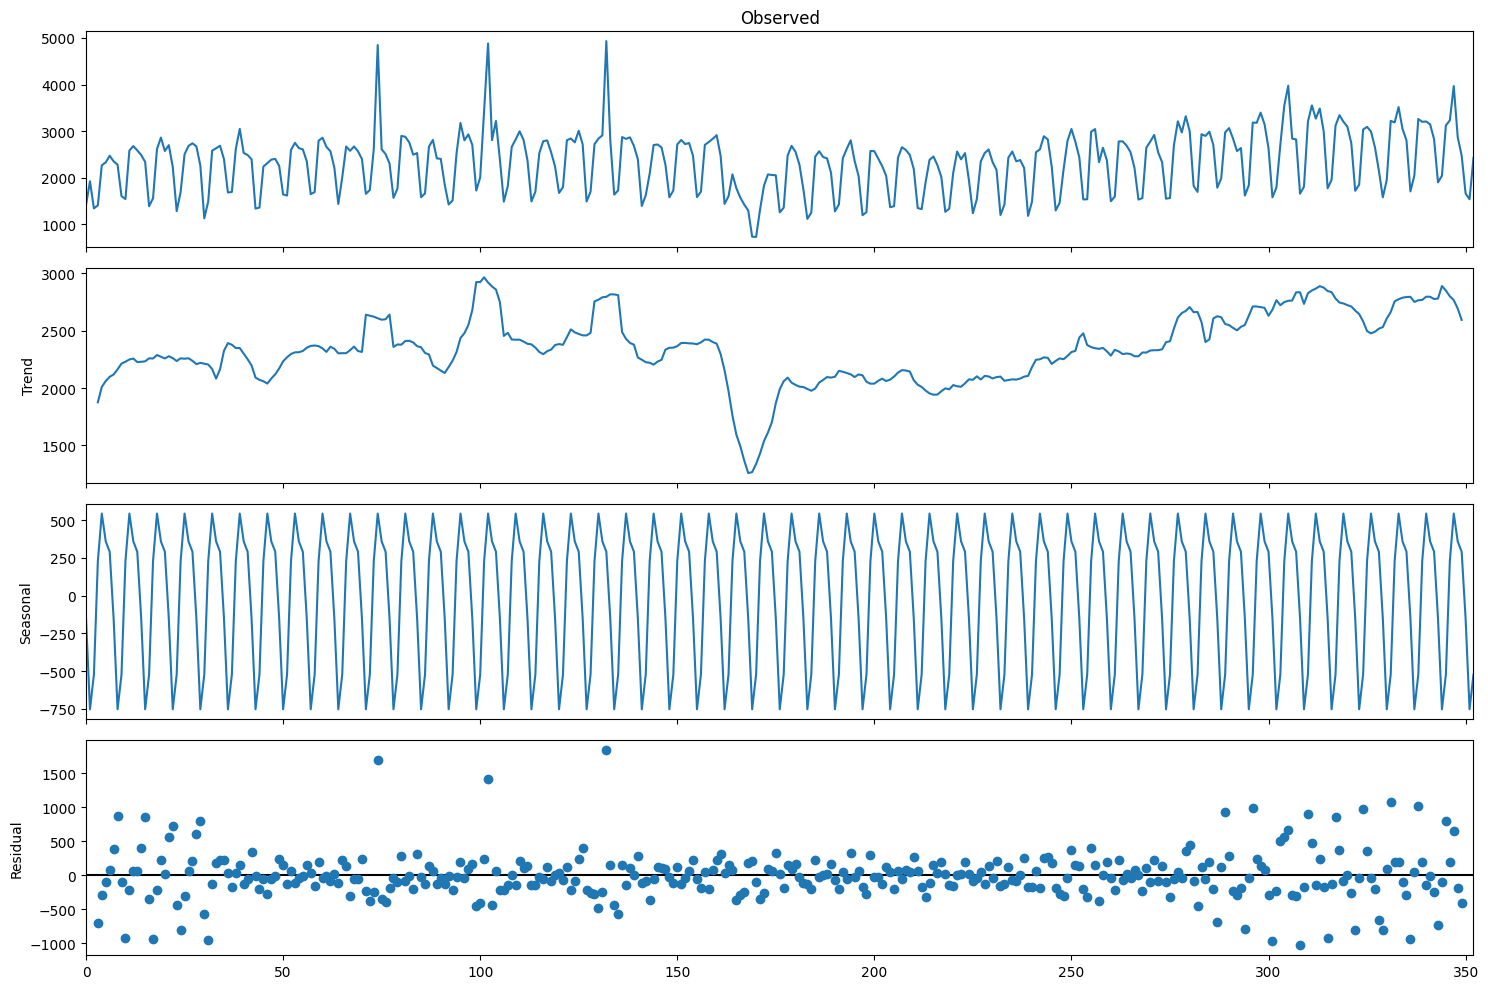

In [16]:
sm.tsa.seasonal_decompose(train_df["y"].values, period=7).plot()
print(sm.tsa.stattools.adfuller(train_df["y"])[1])

3.318328400878577e-08


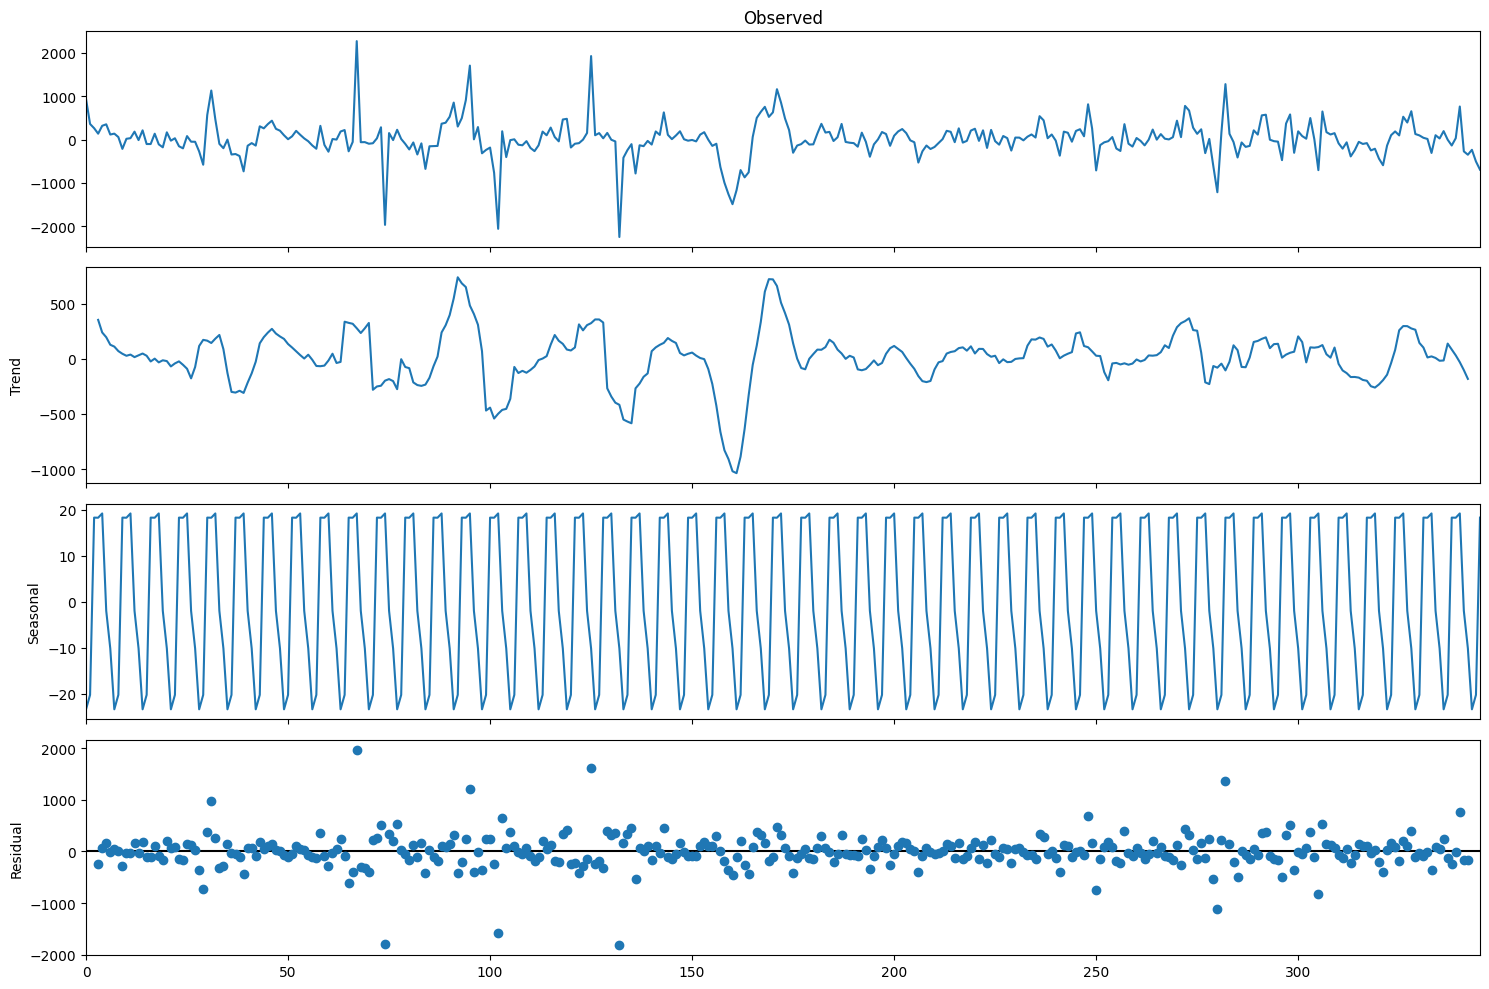

In [17]:
train_df.set_index("ds", inplace=True)
train_df["y_diff"] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, period=7).plot()
print(sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

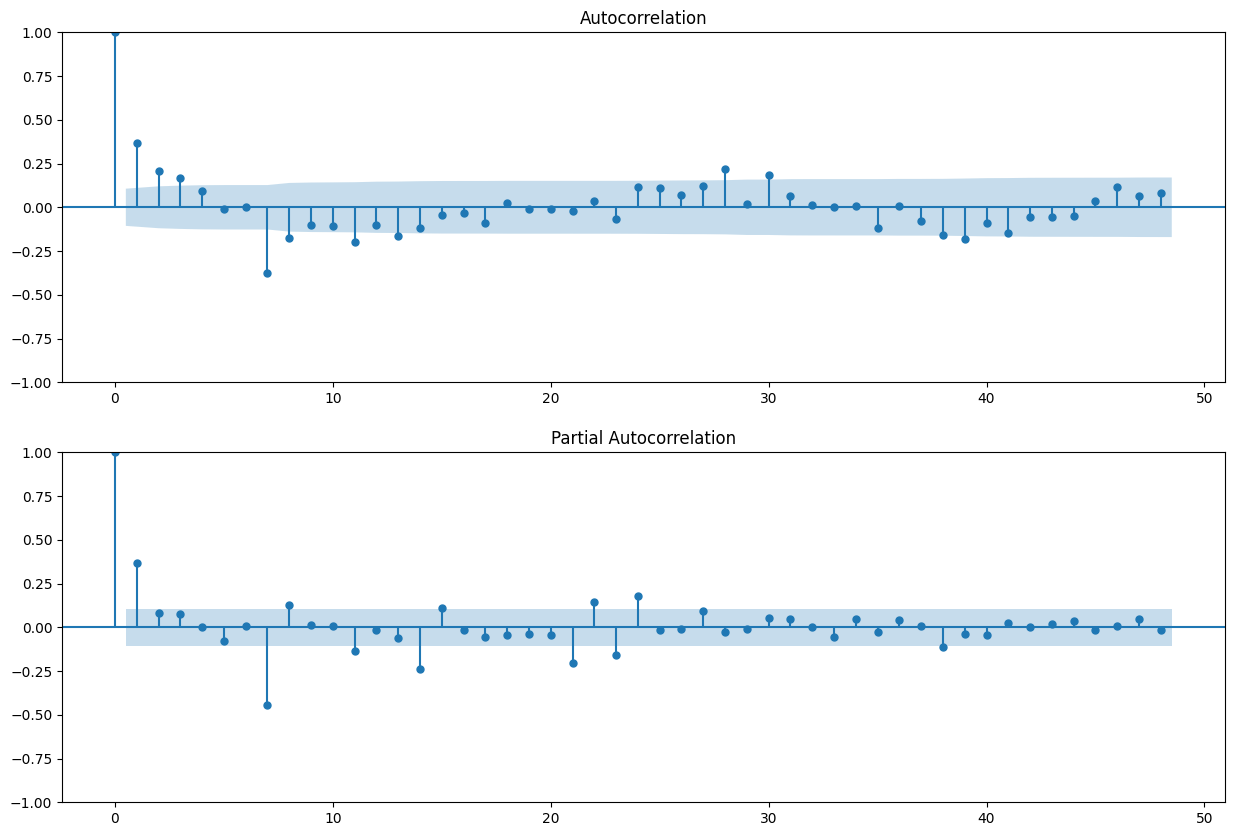

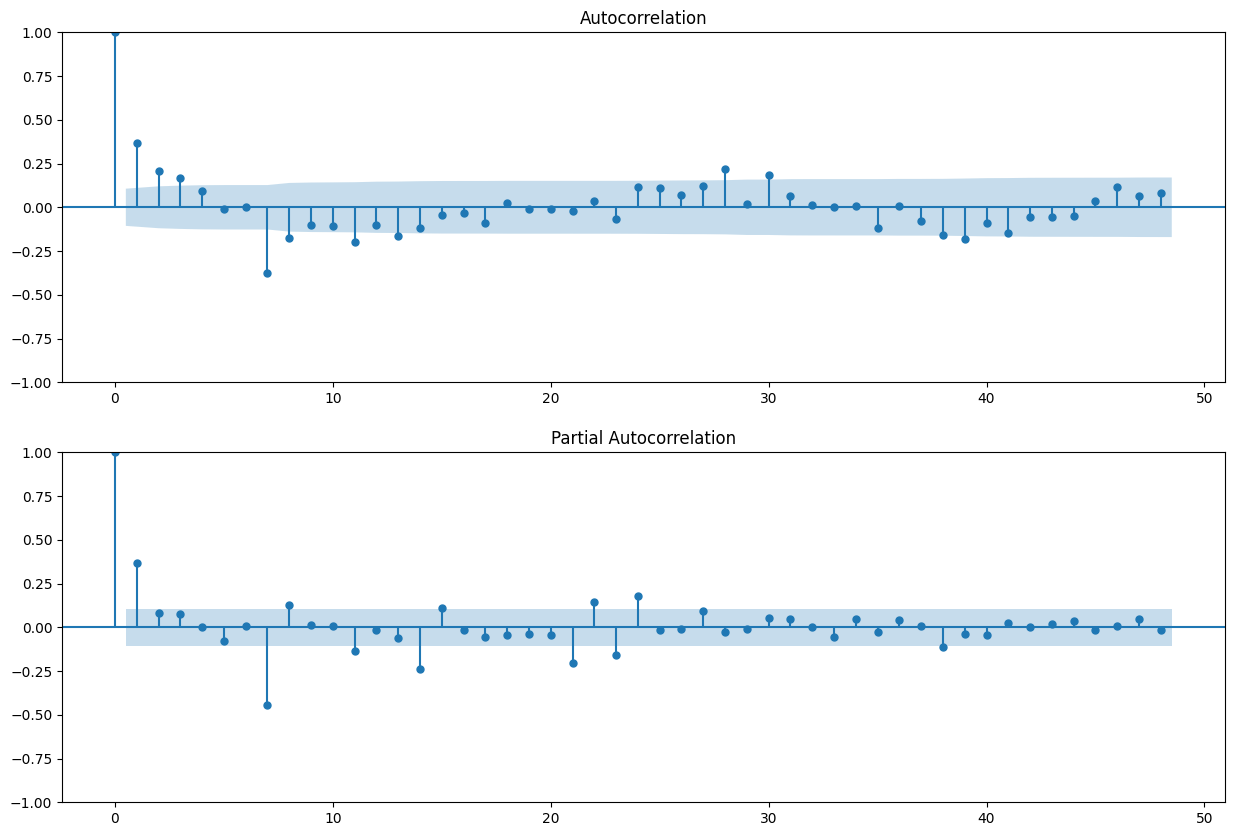

In [18]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

In [19]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [22]:
import scipy.stats

train_df["y_box"], lmbda = scipy.stats.boxcox(train_df["y"])
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [23]:
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y_box"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
            enforce_stationary=False,  
            enforce_invertibility=False  
        ).fit(disp=-1)

    except (ValueError, np.linalg.LinAlgError):
        continue

    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings("default")

  0%|          | 0/384 [00:00<?, ?it/s]

In [29]:
result_table = pd.DataFrame(results2)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by="aic", ascending=True).head())

             parameters          aic
36   (0, 0, 1, 2, 0, 0)     8.000000
37   (0, 0, 1, 2, 0, 1)    10.000000
327  (1, 1, 1, 3, 0, 0)    12.000000
82   (0, 0, 3, 2, 0, 0)    12.000000
260  (1, 0, 2, 3, 2, 1)  3528.466489


In [30]:
result_table[
    result_table2["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
].sort_values(by="aic")

,parameters,aic
257,"(1, 0, 2, 3, 1, 0)",3556.880231
354,"(1, 1, 2, 3, 1, 1)",3557.951378
356,"(1, 1, 2, 3, 2, 1)",3558.582303
256,"(1, 0, 2, 3, 0, 0)",3679.618305


In [31]:
best_model = sm.tsa.statespace.SARIMAX(
    train_df["y_box"],
    order=(1, 0, 2),
    seasonal_order=(3, 2, 1, 7),
    enforce_stationary=False,  
    enforce_invertibility=False  
).fit(disp=-1)

C:\Users\Sava\python_projects\параллельные приколы\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Sava\python_projects\параллельные приколы\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['enforce_stationary']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

C:\Users\Sava\python_projects\параллельные приколы\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [32]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, [1], 7)   Log Likelihood               -1756.233
Date:                             Wed, 17 Apr 2024   AIC                           3528.466
Time:                                     21:42:19   BIC                           3559.074
Sample:                                          0   HQIC                          3540.664
                                             - 353                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8311      0.113      7.342      0.000       0.609       1.053
ma.L1         -0.3514      

In [40]:
# train_df["arima_model"] = best_model
# train_df.y.tail(200).plot()
# train_df["arima_model"] = best_model.predict(start=train_df.index.min(), end=train_df.index.max())
# train_df.arima_model[13:].tail(200).plot(color="r")
# plt.ylabel("wiki pageviews");

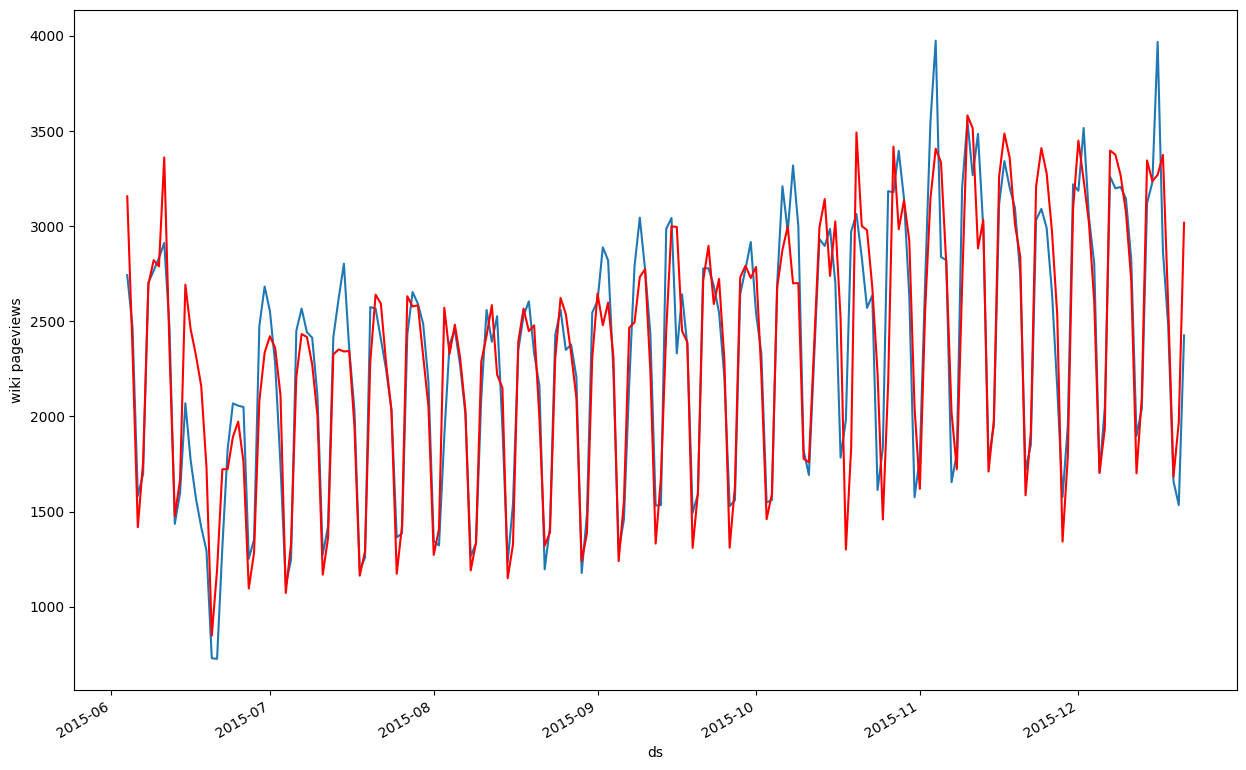

In [42]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

train_df["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color="r")
plt.ylabel("wiki pageviews");